In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

### General Exploration

In [4]:
data.shape

(1460, 81)

In [5]:
data.isna().values.sum()

6965

#### There seem to be a large number of NA values

In [6]:
cols_w_na = data.columns[data.isna().sum()>0].tolist()
cols_w_na

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [7]:
data[cols_w_na].dtypes

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

#### Based on the documentation, it seems that NA values have meaning for most columns. For these columns, let's replace NA with the string "None" as not to include them as dirty values. Or it they are a numberic column, replace NA with 0

Columns with NA:
* LotFrontage: NA should be 0
* MasVnrType: NA is dirty
* MasVnrArea: NA is dirty
* NA isn't dirty for all of the rest

In [8]:
for col in data.columns:
    if(data[col].dtype=='object'):
        data[col] = data[col].fillna("None")
    else:
        data[col] = data[col].fillna(0)

In [9]:
print(data.isna().values.sum())
data.shape

0


(1460, 81)

#### Now that all NA values have been dealt with, we should take a look at other numeric columns and check for outliers

In [10]:
numeric = [col for col in data.columns if data[col].dtype!='object']
numeric.remove('Id')
print(data[numeric].describe())

        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    57.623288   10516.828082     6.099315     5.575342   
std      42.300571    34.664304    9981.264932     1.382997     1.112799   
min      20.000000     0.000000    1300.000000     1.000000     1.000000   
25%      20.000000    42.000000    7553.500000     5.000000     5.000000   
50%      50.000000    63.000000    9478.500000     6.000000     5.000000   
75%      70.000000    79.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.117123   443.639726    46.549315  ...   
std      30.202904     20.645407   180.731373   456.098091   161.319273  ..

### All values seem reasonable. Next we need to figure out how to transform the text columns using either label or one-hot-encoding

In [11]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [12]:
one_hot = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour', #could maybe be label
    'LotConfig',
    'LandSlope', #could be label
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType', #could be label
    'HouseStyle', #could be label
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating', #could be label
    'GarageType', #could be label
    'MiscFeature',
    'SaleType',#could be label
    'SaleCondition', #could be label
]

label = {
    'Utilities': {'None': 0, np.nan: 0, 'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4},
    'ExterQual': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'ExterCond': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtQual': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtExposure': {'None': 0, np.nan: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, np.nan: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'None': 0, np.nan: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'HeatingQC': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'CentralAir': {'None': 0, np.nan: 0, 'N': 1, 'Y': 2},
    'Electrical': {'None': 0, np.nan: 0, 'FuseP': 1, 'Mix': 2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
    'KitchenQual': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'Functional': {'None': 0, np.nan: 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8},
    'FireplaceQu': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'None': 0, np.nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'GarageQual': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'PavedDrive': {'None': 0, np.nan: 0, 'N': 1, 'P': 2, 'Y': 3},
    'PoolQC': {'None': 0, np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'Fence': {'None': 0, np.nan: 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
}

In [13]:
label_numeric_df = data[set(data.columns) - set(one_hot)]

for col in label_numeric_df.columns:
    if col in label:
        label_numeric_df[col] = label_numeric_df[col].replace(label[col])

label_numeric_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,ExterQual,BsmtFinSF2,BsmtFinType2,BsmtFullBath,HeatingQC,BsmtHalfBath,YearBuilt,2ndFlrSF,OverallCond,Electrical,...,GarageCars,EnclosedPorch,SalePrice,GarageArea,PavedDrive,BsmtExposure,TotalBsmtSF,YrSold,MoSold,ExterCond
0,4,0,1,1,5,0,2003,854,5,5,...,2,0,208500,548,3,1,856,2008,2,3
1,3,0,1,0,5,1,1976,0,8,5,...,2,0,181500,460,3,4,1262,2007,5,3
2,4,0,1,1,5,0,2001,866,5,5,...,2,0,223500,608,3,2,920,2008,9,3
3,3,0,1,1,4,0,1915,756,5,5,...,3,272,140000,642,3,1,756,2006,2,3
4,4,0,1,1,5,0,2000,1053,5,5,...,3,0,250000,836,3,3,1145,2008,12,3


In [14]:
one_hot_df = data[one_hot]
one_hot_df['MSSubClass'] = one_hot_df['MSSubClass'].astype('str')
one_hot_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,GarageType,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Attchd,None,WD,Normal
1,20,RL,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Attchd,None,WD,Normal
2,60,RL,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Attchd,None,WD,Normal
3,70,RL,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Detchd,None,WD,Abnorml
4,60,RL,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Attchd,None,WD,Normal


In [15]:
import seaborn as sns
from sklearn.model_selection import train_test_split

In [16]:
full_df = label_numeric_df.join(one_hot_df)
full_df.shape

(1460, 81)

In [17]:
X = full_df.drop('SalePrice', axis=1).values
y = full_df[['SalePrice']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = pd.DataFrame(X_train, columns=full_df.drop('SalePrice', axis=1).columns)
y_train = pd.DataFrame(y_train, columns=['SalePrice'])

In [18]:
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.40, random_state=42)
X_test = pd.DataFrame(X_test, columns=full_df.drop('SalePrice', axis=1).columns)
y_test = pd.DataFrame(y_test, columns=['SalePrice'])

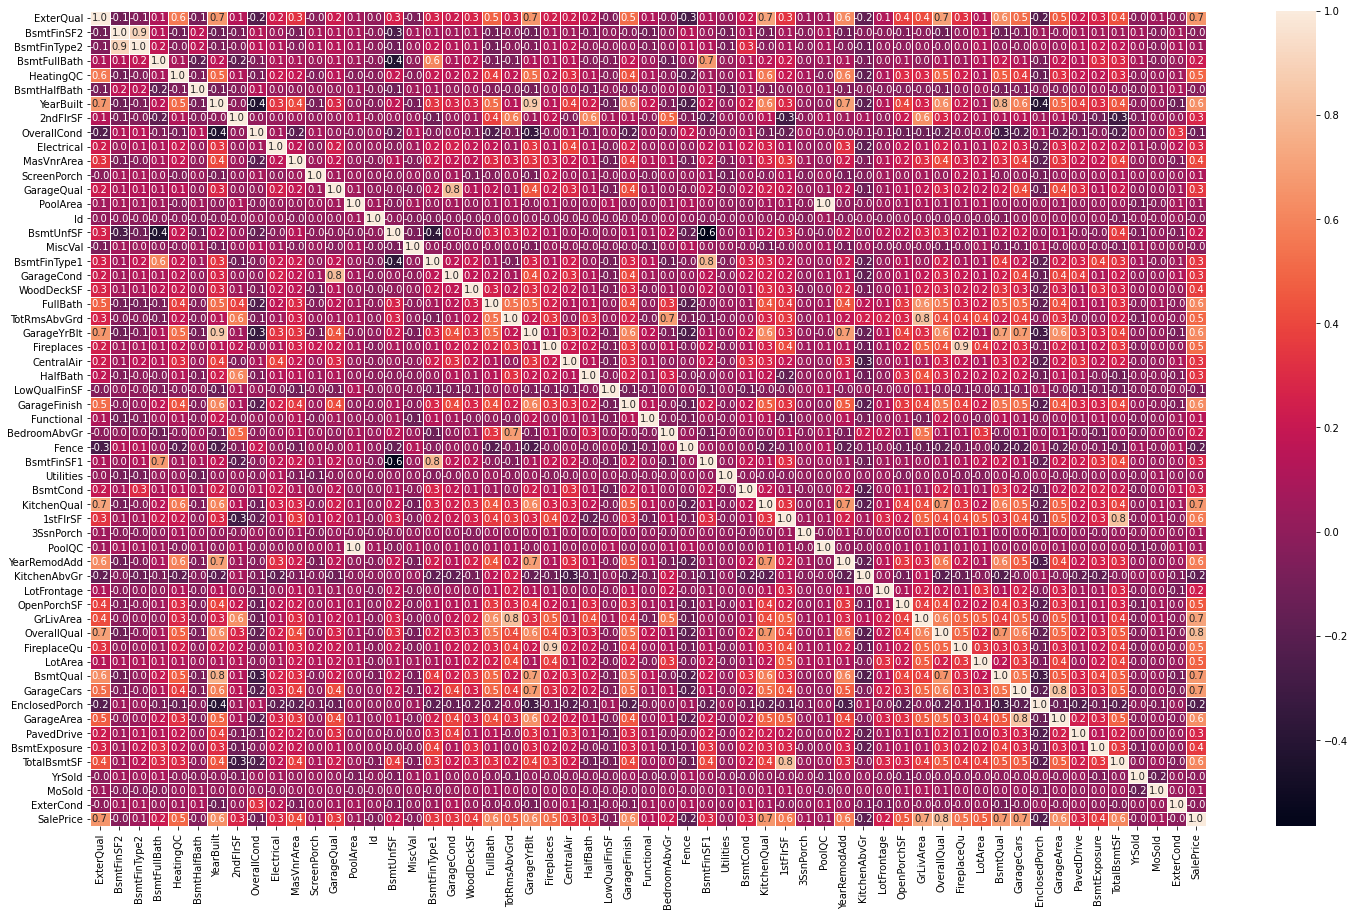

In [19]:
fig = plt.figure(figsize=(25,15))
corr_matrix = (X_train[label_numeric_df.drop('SalePrice', axis=1).columns].join(y_train)).astype('float64').corr(method='spearman')
heat = sns.heatmap(corr_matrix, linewidths=1, annot=True, fmt='.1f')
fig.savefig('heatmap.png', dpi=200)

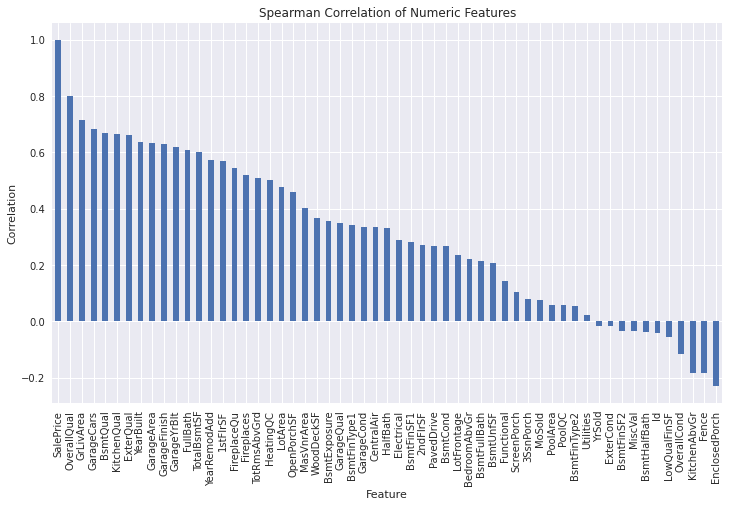

In [20]:
plt.style.use('seaborn')

corr_matrix['SalePrice'].sort_values(ascending=False).plot.bar(figsize=(12,7), 
                                                                     xlabel='Feature', 
                                                                     ylabel='Correlation',
                                                                     title='Spearman Correlation of Numeric Features')
plt.savefig('saleprice_corr.png', dpi=200)

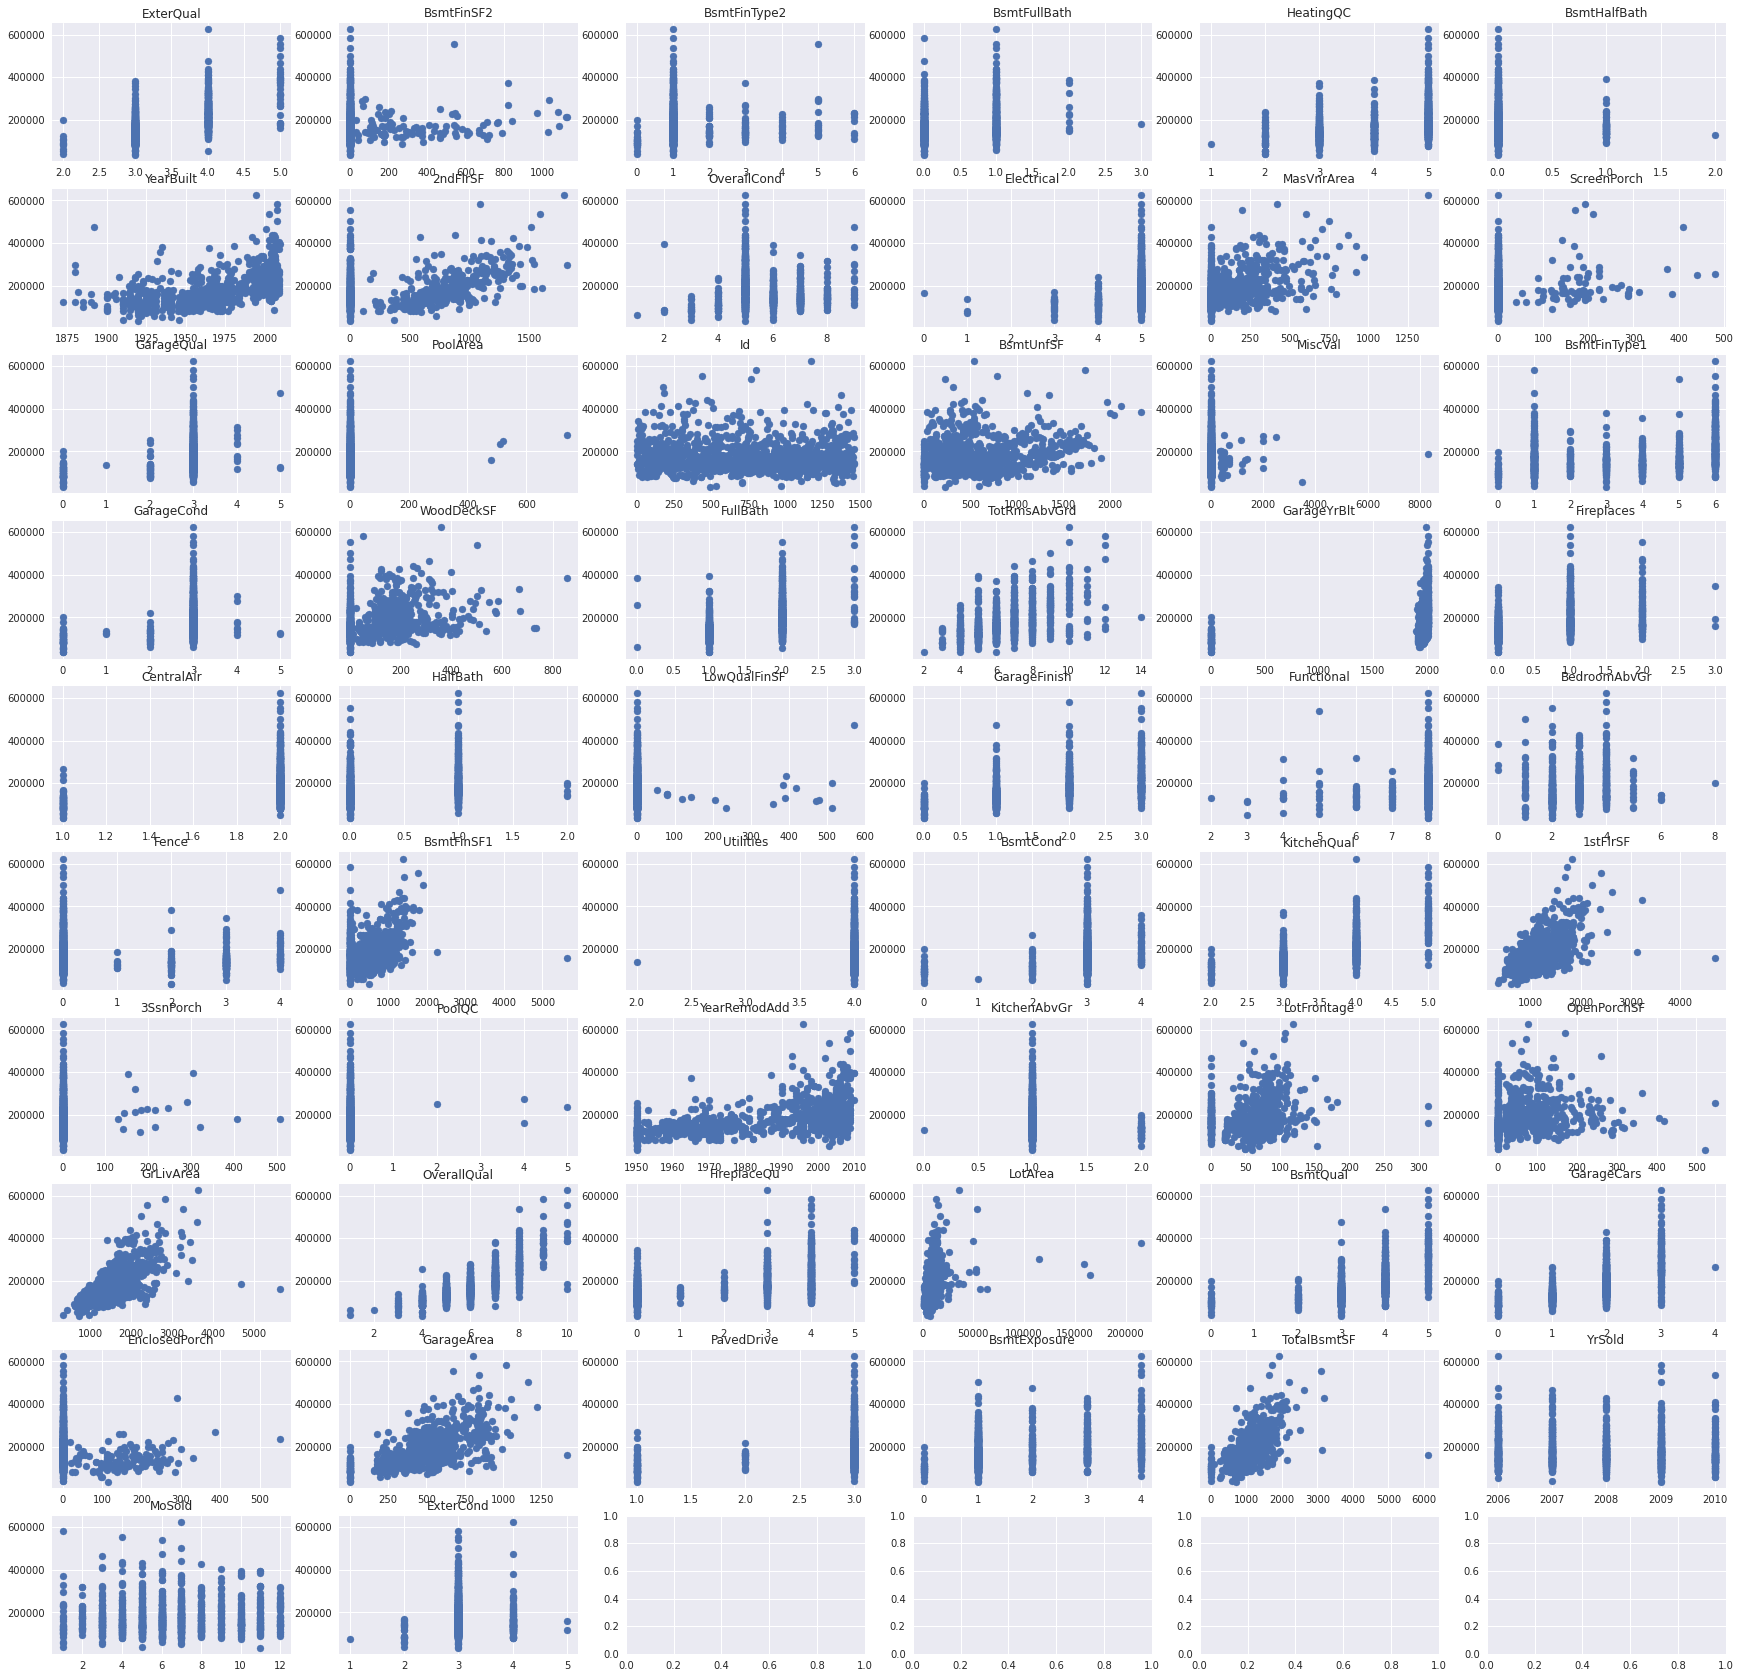

In [21]:
fig, axs = plt.subplots(nrows=10,ncols=6,figsize=(30, 30))
row_count = 0
col_count = 0

for dp in label_numeric_df.columns:
    if(dp=='SalePrice'):
        continue
    x = X_train[dp].values
    y = y_train
    axs[row_count,col_count].scatter(x, y)
    axs[row_count,col_count].set_title(dp)

    if col_count == 5:
        row_count+=1
        col_count=0
    else:
        col_count+=1
    
fig.show()

In [22]:
base_line = corr_matrix[corr_matrix['SalePrice'] >= 0.6].index.tolist()
base_line.remove('SalePrice')
base_line
#base_line = label_numeric_df.drop('SalePrice', axis=1).columns.tolist()

['ExterQual',
 'YearBuilt',
 'FullBath',
 'GarageYrBlt',
 'GarageFinish',
 'KitchenQual',
 'GrLivArea',
 'OverallQual',
 'BsmtQual',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF']

<AxesSubplot:>

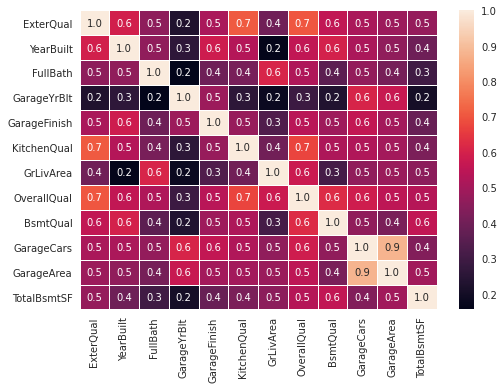

In [23]:
sns.heatmap(X_train[base_line].astype('float64').corr(), linewidths=1, annot=True, fmt='.1f')

In [24]:
base_line.remove('GarageArea')
base_line.remove('KitchenQual')
base_line.remove('ExterQual')
base_line

['YearBuilt',
 'FullBath',
 'GarageYrBlt',
 'GarageFinish',
 'GrLivArea',
 'OverallQual',
 'BsmtQual',
 'GarageCars',
 'TotalBsmtSF']

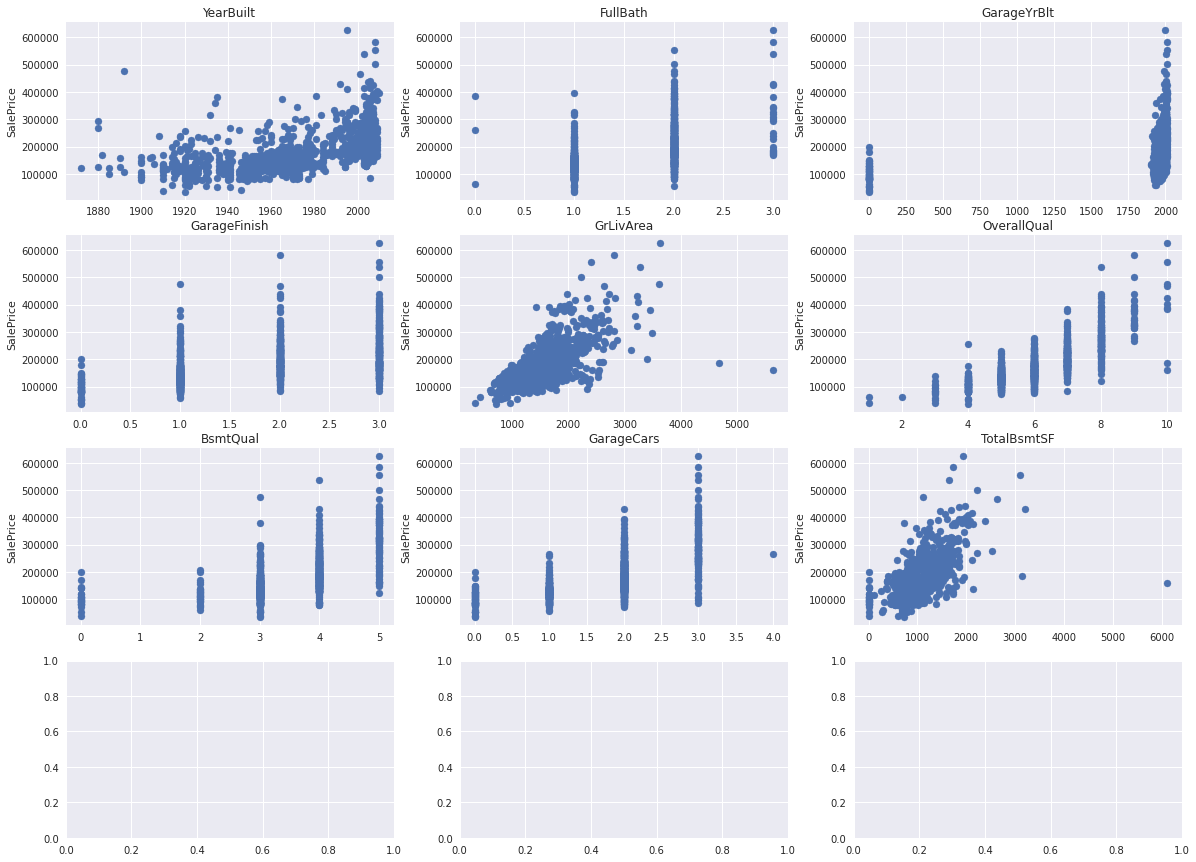

In [25]:
fig, axs = plt.subplots(nrows=4,ncols=3,figsize=(20, 15))
row_count = 0
col_count = 0

for dp in base_line:
    if(dp=='SalePrice'):
        continue
    x = X_train[dp].values
    y = y_train
    axs[row_count,col_count].scatter(x, y)
    axs[row_count,col_count].set_title(dp)
    axs[row_count,col_count].set_ylabel('SalePrice')

    if col_count == 2:
        row_count+=1
        col_count=0
    else:
        col_count+=1
    
fig.show()

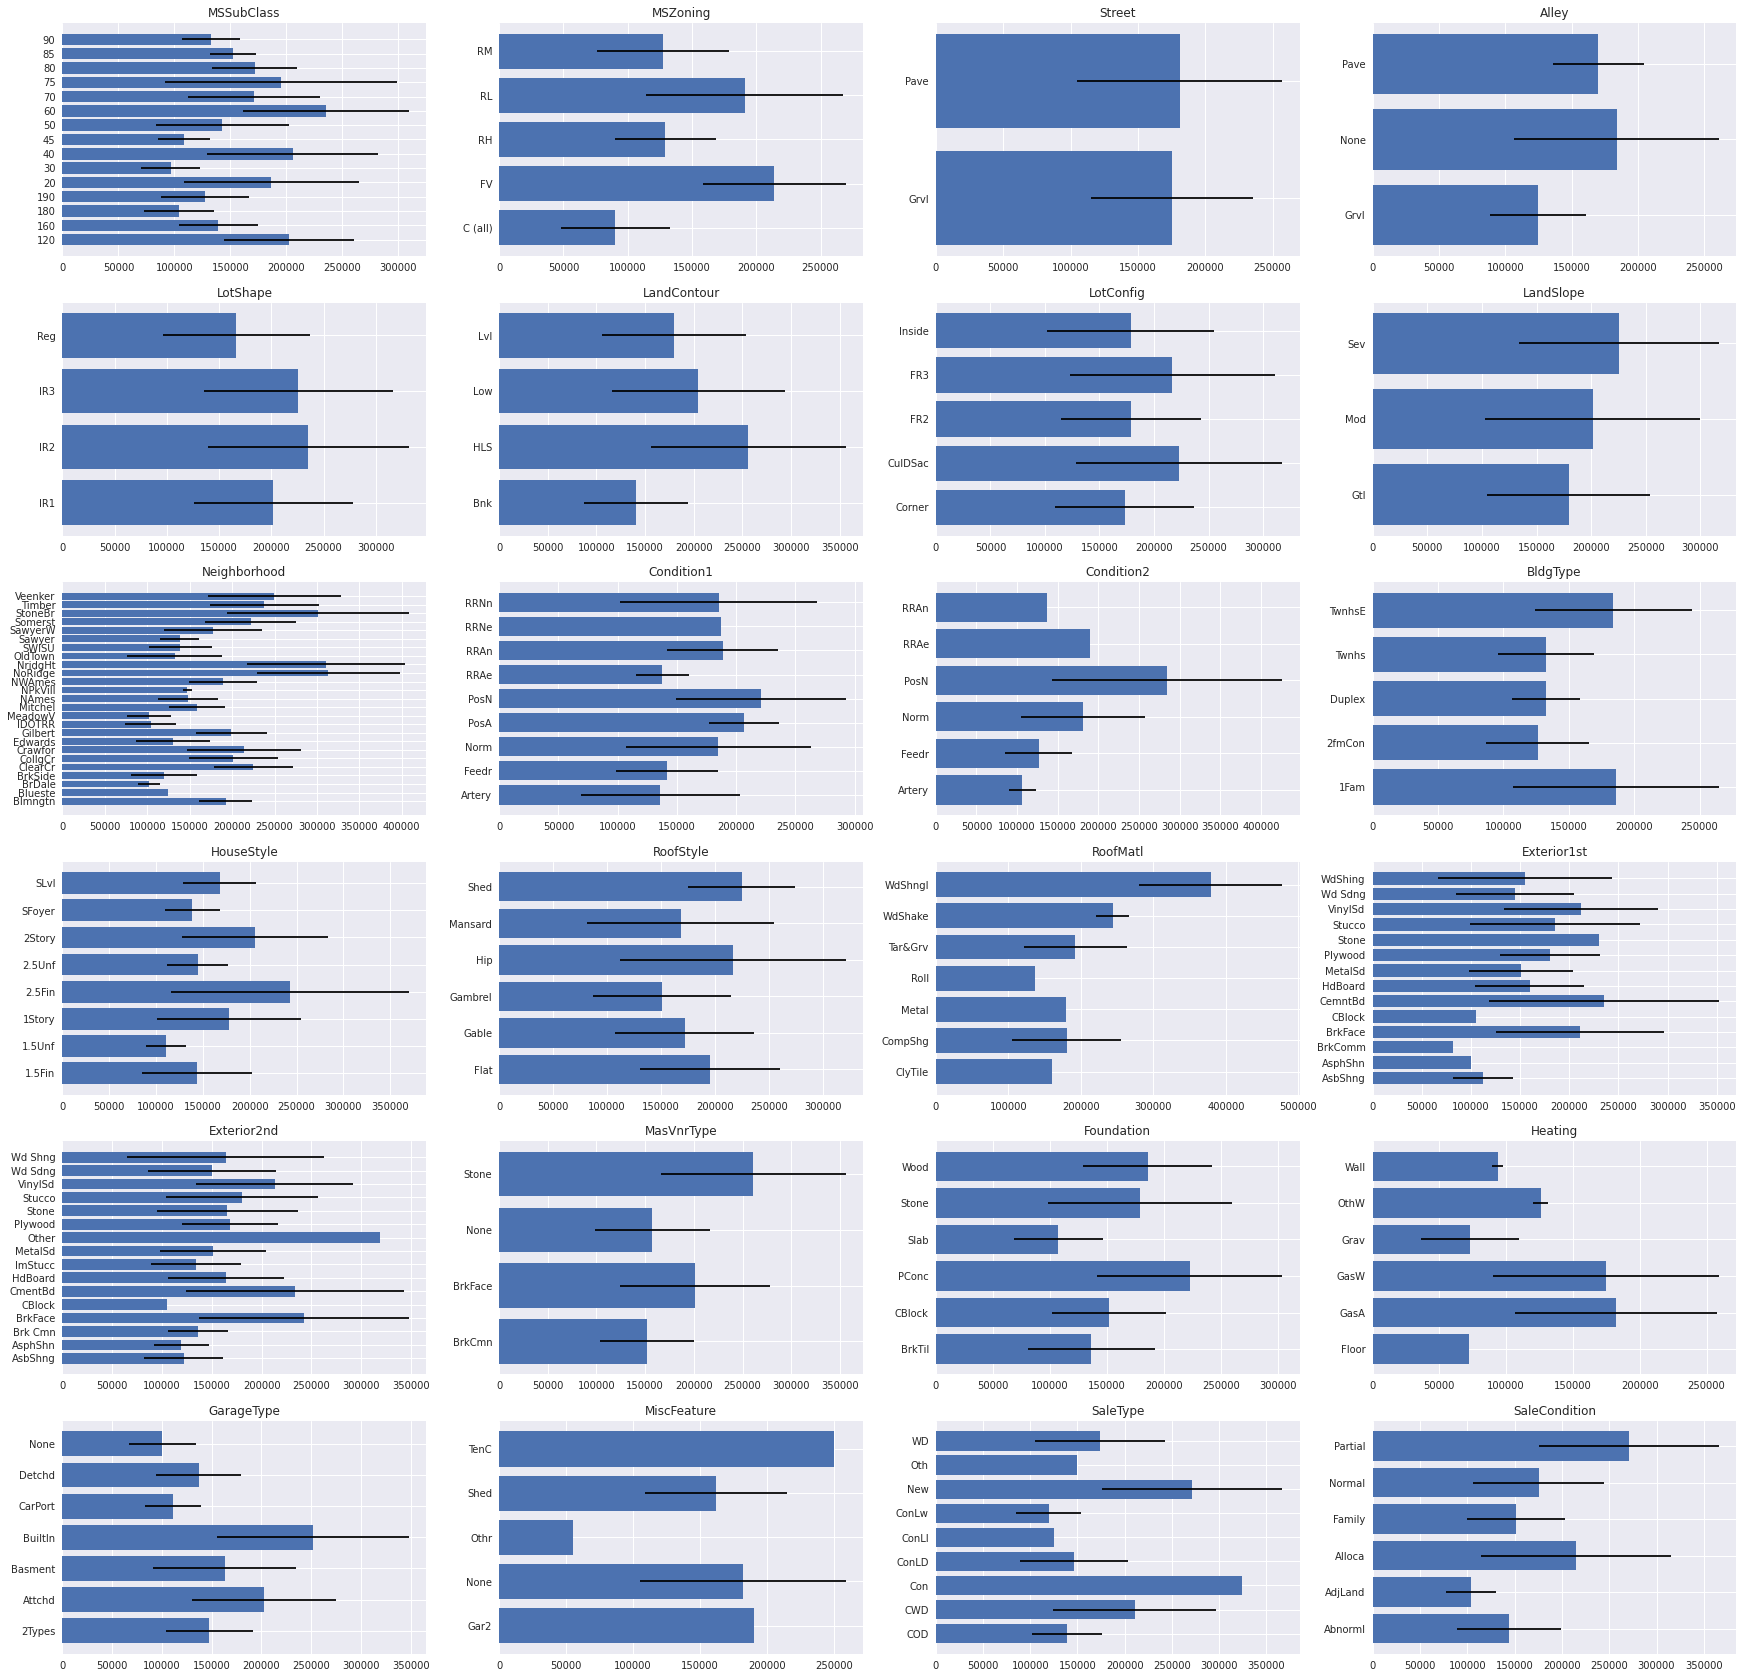

In [26]:
fig, axs = plt.subplots(nrows=6,ncols=4,figsize=(30, 30))
row_count = 0
col_count = 0

for dp in one_hot:
    means = X_train.join(y_train)[[dp, 'SalePrice']].groupby(dp).mean()
    y = [str(x) for x in means.index]
    means = means['SalePrice']
    stds = X_train.join(y_train)[[dp, 'SalePrice']].groupby(dp).std()['SalePrice']
    axs[row_count,col_count].barh(y, means, xerr=stds)
    axs[row_count,col_count].set_title(dp)

    if col_count == 3:
        row_count+=1
        col_count=0
    else:
        col_count+=1
    
fig.show()

In [27]:
one_hot_base = ['MSSubClass', 'Neighborhood', 'GarageType', 'SaleType']
#one_hot_base = one_hot

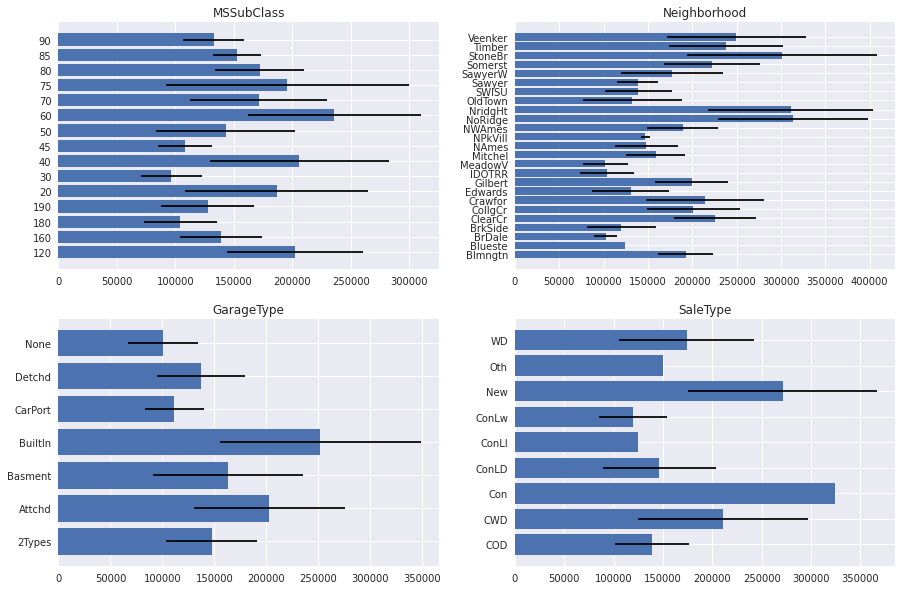

In [28]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(15, 10))
row_count = 0
col_count = 0

for dp in one_hot_base:
    means = X_train.join(y_train)[[dp, 'SalePrice']].groupby(dp).mean()
    y = [str(x) for x in means.index]
    means = means['SalePrice']
    stds = X_train.join(y_train)[[dp, 'SalePrice']].groupby(dp).std()['SalePrice']
    axs[row_count,col_count].barh(y, means, xerr=stds)
    axs[row_count,col_count].set_title(dp)

    if col_count == 1:
        row_count+=1
        col_count=0
    else:
        col_count+=1

fig.savefig('one_hot.png', dpi=200)
fig.show()

In [29]:
one_hot_base.remove('MSSubClass')
one_hot_base.remove('GarageType')
one_hot_base.remove('SaleType')

#### Let's make a baseline model with all of the correlations at or above 0.65 and see how it does

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [31]:
print(base_line)
print(one_hot_base)

['YearBuilt', 'FullBath', 'GarageYrBlt', 'GarageFinish', 'GrLivArea', 'OverallQual', 'BsmtQual', 'GarageCars', 'TotalBsmtSF']
['Neighborhood']


In [32]:
enc = OneHotEncoder().fit(X_train[one_hot_base])
enc.transform(X_train[one_hot_base]).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [33]:
scaler = StandardScaler().fit(X_train[base_line].astype('float64'))
scaler.transform(X_train[base_line].astype('float64'))

array([[-0.26050401, -1.07068735,  0.20401448, ..., -0.55169879,
         0.29309491, -0.2754465 ],
       [ 1.1709873 , -1.07068735, -4.17154945, ...,  0.57945722,
        -2.43687485,  0.13575922],
       [ 1.10591951,  0.76638674,  0.29763327, ...,  0.57945722,
         1.6580798 ,  1.24422683],
       ...,
       [-0.52077515, -1.07068735,  0.19064037, ..., -0.55169879,
         0.29309491, -0.43635309],
       [-1.72452921, -1.07068735,  0.11931176, ..., -0.55169879,
        -1.07188997, -0.32908203],
       [ 1.1709873 ,  0.76638674,  0.30209131, ...,  0.57945722,
         1.6580798 ,  0.70116709]])

In [34]:
X_train_base = np.concatenate((scaler.transform(X_train[base_line].astype('float64')), enc.transform(X_train[one_hot_base]).toarray()), axis=1)
X_test_base = np.concatenate((scaler.transform(X_test[base_line].astype('float64')), enc.transform(X_test[one_hot_base]).toarray()), axis=1)

In [35]:
models = [
    ('LR', LinearRegression()),
    
    ('KNN', KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto',
                                leaf_size=25)),
    
    ('GB', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=7,
                                        min_samples_leaf=7, loss='huber', random_state =42)),
    
    ('RF', RandomForestRegressor(random_state=0))
]

def test_models(pred, actual, m, trained=False):
    for model in m:
        print(model[0])
        if(not trained):
            model[1].fit(pred, actual)
        scores = np.sqrt(-cross_val_score(model[1], pred, actual, cv = 12, scoring = "neg_mean_squared_error"))
        mean = np.mean(scores)
        print("Mean CV score: ",mean)
        
        y_pred = model[1].predict(pred)
        rmse_ = np.sqrt(metrics.mean_squared_error(y_pred, actual))
        print('r2:', r2_score(model[1].predict(pred), actual))
        print("rmse: ", rmse_)

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
test_models(X_train_base, np.log(y_train.values), models)

LR
Mean CV score:  0.1644558628284624
r2: 0.8092723879612964
rmse:  0.1570504773852945
KNN
Mean CV score:  0.17166710779583472
r2: 0.8467891602102741
rmse:  0.13935817701828335
GB
Mean CV score:  0.16153425711199645
r2: 0.9578931128413438
rmse:  0.0764520367775705
RF
Mean CV score:  0.15930425398033818
r2: 0.9744862813327086
rmse:  0.059601310137374394


In [38]:
test_models(X_test_base, np.log(y_test.values), models, trained=True)

LR
Mean CV score:  0.16104586341609664
r2: 0.8215102296494636
rmse:  0.15720309750509517
KNN
Mean CV score:  0.20547924868096598
r2: 0.7743973435674273
rmse:  0.1756050655509344
GB
Mean CV score:  0.1790272051835683
r2: 0.8101551311335997
rmse:  0.16470265243782184
RF
Mean CV score:  0.18439329682707406
r2: 0.8038348885472559
rmse:  0.1671132268769486


In [39]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train_base, np.log(y_train.values))

RandomForestRegressor(random_state=0)

In [40]:
X_validation = pd.DataFrame(X_validation, columns=full_df.drop('SalePrice', axis=1).columns)

print(model.score(np.concatenate((scaler.transform(X_validation[base_line].astype('float64')), enc.transform(X_validation[one_hot_base]).toarray()), axis=1), 
            np.log(y_validation)))
scores = np.sqrt(-cross_val_score(model, np.concatenate((scaler.transform(X_validation[base_line].astype('float64')), 
                                                         enc.transform(X_validation[one_hot_base]).toarray()), axis=1), 
                                  np.log(y_validation), cv = 12, scoring = "neg_mean_squared_error"))
mean = np.mean(scores)
print("Mean CV score: ",mean)

0.8855992646603664
Mean CV score:  0.1537427837528585


In [41]:
model = LinearRegression()
model.fit(np.concatenate((scaler.transform(full_df[base_line].astype('float64')), enc.transform(full_df[one_hot_base]).toarray()), axis=1), 
          np.log(full_df['SalePrice'].values))

LinearRegression()

In [42]:
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [43]:
for col in submission.columns:
    if(submission[col].dtype=='object'):
        submission[col] = submission[col].fillna("None")
    else:
        submission[col] = submission[col].fillna(0)

submission.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,...,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,...,0,0,None,MnPrv,None,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,...,144,0,None,None,None,0,1,2010,WD,Normal


In [44]:
label_numeric_df = submission[set(submission.columns) - set(one_hot)]

for col in label_numeric_df.columns:
    if col in label:
        label_numeric_df[col] = label_numeric_df[col].replace(label[col])

label_numeric_df.head()

,ExterQual,BsmtFinSF2,BsmtFinType2,BsmtFullBath,HeatingQC,BsmtHalfBath,YearBuilt,2ndFlrSF,OverallCond,Electrical,...,BsmtQual,GarageCars,EnclosedPorch,GarageArea,PavedDrive,BsmtExposure,TotalBsmtSF,YrSold,MoSold,ExterCond
0,3,144.0,2,0.0,3,0.0,1961,0,6,5,...,3,1.0,0,730.0,3,1,882.0,2010,6,3
1,3,0.0,1,0.0,3,0.0,1958,0,6,5,...,3,1.0,0,312.0,3,1,1329.0,2010,6,3
2,3,0.0,1,0.0,4,0.0,1997,701,5,5,...,4,2.0,0,482.0,3,1,928.0,2010,3,3
3,3,0.0,1,0.0,5,0.0,1998,678,6,5,...,3,2.0,0,470.0,3,1,926.0,2010,6,3
4,4,0.0,1,0.0,5,0.0,1992,0,5,5,...,4,2.0,0,506.0,3,1,1280.0,2010,1,3


In [45]:
one_hot_df = submission[one_hot]
one_hot_df.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,GarageType,MiscFeature,SaleType,SaleCondition
0,20,RH,Pave,None,Reg,Lvl,Inside,Gtl,NAmes,Feedr,...,CompShg,VinylSd,VinylSd,None,CBlock,GasA,Attchd,None,WD,Normal
1,20,RL,Pave,None,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,CompShg,Wd Sdng,Wd Sdng,BrkFace,CBlock,GasA,Attchd,Gar2,WD,Normal
2,60,RL,Pave,None,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,CompShg,VinylSd,VinylSd,None,PConc,GasA,Attchd,None,WD,Normal
3,60,RL,Pave,None,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Attchd,None,WD,Normal
4,120,RL,Pave,None,IR1,HLS,Inside,Gtl,StoneBr,Norm,...,CompShg,HdBoard,HdBoard,None,PConc,GasA,Attchd,None,WD,Normal


In [46]:
submission_df = label_numeric_df.join(one_hot_df)
submission_df.shape

(1459, 80)

In [47]:
submission_df.head()

,ExterQual,BsmtFinSF2,BsmtFinType2,BsmtFullBath,HeatingQC,BsmtHalfBath,YearBuilt,2ndFlrSF,OverallCond,Electrical,...,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,GarageType,MiscFeature,SaleType,SaleCondition
0,3,144.0,2,0.0,3,0.0,1961,0,6,5,...,CompShg,VinylSd,VinylSd,None,CBlock,GasA,Attchd,None,WD,Normal
1,3,0.0,1,0.0,3,0.0,1958,0,6,5,...,CompShg,Wd Sdng,Wd Sdng,BrkFace,CBlock,GasA,Attchd,Gar2,WD,Normal
2,3,0.0,1,0.0,4,0.0,1997,701,5,5,...,CompShg,VinylSd,VinylSd,None,PConc,GasA,Attchd,None,WD,Normal
3,3,0.0,1,0.0,5,0.0,1998,678,6,5,...,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Attchd,None,WD,Normal
4,4,0.0,1,0.0,5,0.0,1992,0,5,5,...,CompShg,HdBoard,HdBoard,None,PConc,GasA,Attchd,None,WD,Normal


In [48]:
ids = submission_df.Id
X = np.concatenate((scaler.transform(submission_df[base_line].astype('float64')), enc.transform(submission_df[one_hot_base]).toarray()), axis=1)

In [49]:
predictions = pd.DataFrame({'Id': ids,
                            'SalePrice': np.exp(model.predict(X))
                           })
predictions

,Id,SalePrice
0,1461,119192.918076
1,1462,146837.610809
2,1463,168665.568180
3,1464,176168.302459
4,1465,232604.483090
...,...,...
1454,2915,80970.376690
1455,2916,90511.702982
1456,2917,137774.974786
1457,2918,114394.136326


In [50]:
predictions.to_csv('submission_file.csv',index=False)